# Part 1: Exploration

In [1]:
import requests
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import sklearn
import random

# Project: Understanding Lake Erie Weather Patterns for Safer Boating

## Introduction/Motivation

I own a 14-foot fishing boat, which I use on Lake Erie during my summers at home in Erie, Pennsylvania. My boat is quite modest—essentially a large canoe with an outboard motor attached. Despite its size, I venture 5+ miles offshore on a daily basis.

However, Lake Erie is notorious for its rapidly changing weather conditions. These unpredictable shifts can make boating dangerous, especially when you are far from shore (and have only 25 horsepower to propel you back). In an effort to enhance my safety, I am undertaking this project to analyze weather and lake data. My goal is to identify patterns that could help me better understand how the lake behaves, potentially providing valuable insights for safer trips.

**A NOTE: I have been working on this project whenever I have had free time since we were told about it. (And been loving every second of it.) But, I have a lot of work, and I don't necissarly know what section they should be in. I am considering moving sections like the lingress plot to prediction or more likely inference. And advice about where sections should be moved would be appreciated**

## Objective

By analyzing historical weather data, I hope to:
- Gain a deeper intuition about the lake's weather patterns
- Identify potential indicators of changing conditions
- Use these insights to make more informed decisions before heading offshore

# Part 1: Exploration

## Part 1a: Buoy Weather Data
### Loading the dataset

In [2]:
data = r'.\data\lake_erie_bouy_data.csv'
concated_weather_data = pd.read_csv(data)
concated_weather_data

,Unnamed: 0,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,0,#yr,mo,dy,hr,mn,degT,m/s,m/s,m,sec,sec,degT,hPa,degC,degC,degC,mi,ft
1,1,2014,05,14,18,40,325,2.7,99.0,0.10,3.00,99.00,266,1017.5,11.7,11.6,999.0,99.0,99.00
2,2,2014,05,16,17,40,348,6.7,99.0,0.60,4.00,99.00,282,1013.5,6.0,11.2,999.0,99.0,99.00
3,3,2014,05,16,18,00,355,6.9,99.0,0.54,4.00,99.00,280,1013.4,6.1,11.2,999.0,99.0,99.00
4,4,2014,05,16,18,20,354,7.2,99.0,0.58,4.00,99.00,280,1013.4,5.9,11.3,999.0,99.0,99.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61451,4860,2021,11,05,14,00,999,3.6,4.3,0.33,3.40,99.00,274,9999.0,6.2,13.0,999.0,99.0,99.00
61452,4861,2021,11,05,14,20,999,3.5,4.6,0.32,3.40,99.00,267,9999.0,6.5,13.0,999.0,99.0,99.00
61453,4862,2021,11,05,14,40,999,3.5,4.6,0.31,3.20,99.00,261,9999.0,6.7,13.0,999.0,99.0,99.00
61454,4863,2021,11,05,15,00,999,3.5,4.7,0.30,3.40,99.00,262,9999.0,6.8,13.0,999.0,99.0,99.00


### Data Cleaning

In [3]:
weather_data = concated_weather_data.copy()
weather_data = weather_data.loc[weather_data['MM'] != 'mo'] # Remove value reference rows

# Convert data to datetime format
weather_data['date'] = pd.to_datetime(weather_data[['#YY', 'MM', 'DD', 'hh', 'mm']].astype(str).agg('/'.join, axis=1), format='%Y/%m/%d/%H/%M')

# Drop unnecessary columns (Don't contain data useful to geographic location) and old date columns.
weather_data_clean = weather_data.drop(columns=['#YY', 'MM', 'DD', 'hh', 'mm', 'APD', 'DEWP', 'VIS', 'TIDE', 'PRES', 'Unnamed: 0'])

# Convert numeric columns
numeric_subset = ['WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'MWD', 'ATMP', 'WTMP']
weather_data_clean[numeric_subset] = weather_data_clean[numeric_subset].apply(pd.to_numeric)
weather_data_clean


,WDIR,WSPD,GST,WVHT,DPD,MWD,ATMP,WTMP,date
1,325,2.7,99.0,0.10,3.0,266,11.7,11.6,2014-05-14 18:40:00
2,348,6.7,99.0,0.60,4.0,282,6.0,11.2,2014-05-16 17:40:00
3,355,6.9,99.0,0.54,4.0,280,6.1,11.2,2014-05-16 18:00:00
4,354,7.2,99.0,0.58,4.0,280,5.9,11.3,2014-05-16 18:20:00
5,357,7.0,99.0,0.57,3.0,286,6.2,11.3,2014-05-16 19:00:00
...,...,...,...,...,...,...,...,...,...
61451,999,3.6,4.3,0.33,3.4,274,6.2,13.0,2021-11-05 14:00:00
61452,999,3.5,4.6,0.32,3.4,267,6.5,13.0,2021-11-05 14:20:00
61453,999,3.5,4.6,0.31,3.2,261,6.7,13.0,2021-11-05 14:40:00
61454,999,3.5,4.7,0.30,3.4,262,6.8,13.0,2021-11-05 15:00:00


### Removing Empty Values

In [4]:
# Replace empty values with Nan

na_key = {
    'WDIR': 999,
    'WSPD': 99,
    'GST': 99,
    'WVHT': 99,
    'DPD': 99,
    'MWD': 999,
    'ATMP': 999,
    'WTMP': 999,
    'PRES': 9999
}


# Iterate through the dictionary
for column, value in na_key.items():
    if column in weather_data_clean.columns:
        # Replace na values with nan
        weather_data_clean[column] = weather_data_clean[column].replace(value, np.nan)

weather_data_clean

,WDIR,WSPD,GST,WVHT,DPD,MWD,ATMP,WTMP,date
1,325.0,2.7,NaN,0.10,3.0,266.0,11.7,11.6,2014-05-14 18:40:00
2,348.0,6.7,NaN,0.60,4.0,282.0,6.0,11.2,2014-05-16 17:40:00
3,355.0,6.9,NaN,0.54,4.0,280.0,6.1,11.2,2014-05-16 18:00:00
4,354.0,7.2,NaN,0.58,4.0,280.0,5.9,11.3,2014-05-16 18:20:00
5,357.0,7.0,NaN,0.57,3.0,286.0,6.2,11.3,2014-05-16 19:00:00
...,...,...,...,...,...,...,...,...,...
61451,NaN,3.6,4.3,0.33,3.4,274.0,6.2,13.0,2021-11-05 14:00:00
61452,NaN,3.5,4.6,0.32,3.4,267.0,6.5,13.0,2021-11-05 14:20:00
61453,NaN,3.5,4.6,0.31,3.2,261.0,6.7,13.0,2021-11-05 14:40:00
61454,NaN,3.5,4.7,0.30,3.4,262.0,6.8,13.0,2021-11-05 15:00:00


### Reference data table

In [5]:
# Data key table for interpretability

data_key = [
    {'code': 'WDIR', 'description': 'Wind Direction', 'unit': 'degrees from N'},
    {'code': 'WSPD', 'description': 'Wind Speed', 'unit': 'm/s'},
    {'code': 'GST', 'description': 'Wind Gust', 'unit': 'm/s'},
    {'code': 'WVHT', 'description': 'Wave Height', 'unit': 'm'},
    {'code': 'DPD', 'description': 'Dominant Wave Period', 'unit': 's'},
    {'code': 'MWD', 'description': 'Mean Wave Direction', 'unit': 'degrees from N'},
    {'code': 'ATMP', 'description': 'Air Temperature', 'unit': 'degrees C'},
    {'code': 'WTMP', 'description': 'Water Surface Temperature', 'unit': 'degrees C'}
]

key_df = pd.DataFrame(data_key)
key_df

,code,description,unit
0,WDIR,Wind Direction,degrees from N
1,WSPD,Wind Speed,m/s
2,GST,Wind Gust,m/s
3,WVHT,Wave Height,m
4,DPD,Dominant Wave Period,s
5,MWD,Mean Wave Direction,degrees from N
6,ATMP,Air Temperature,degrees C
7,WTMP,Water Surface Temperature,degrees C


#### Mapping Numbers to Qualitative Data

In [6]:
# I wanted to see how more detailed data effected my model. 

def deg_to_cardinal(degrees: int) -> str:    
    if 0 <= degrees < 22.5 or 337.5 <= degrees <= 360:
        return 'North'
    elif 22.5 <= degrees < 67.5:
        return 'Northeast'
    elif 67.5 <= degrees < 112.5:
        return 'East'
    elif 112.5 <= degrees < 157.5:
        return 'Southeast'
    elif 157.5 <= degrees < 202.5:
        return 'South'
    elif 202.5 <= degrees < 247.5:
        return 'Southwest'
    elif 247.5 <= degrees < 292.5:
        return 'West'
    elif 292.5 <= degrees < 337.5:
        return 'Northwest'
    else:
        return 'Invalid direction'

In [7]:
# Mapping degrees from north to the cardinal directions
def deg_to_cardinal(dir: int) -> str:
    if dir <= 45 or (337.5 < dir < 360):
        return 'North'
    elif 45 < dir <= 135:
        return 'East'
    elif 135 < dir <= 225:
        return 'South'
    elif 225 < dir <= 315:
        return 'West'
    

weather_data_clean.loc[:, "CWDIR"] = weather_data_clean['WDIR'].apply(deg_to_cardinal)
weather_data_clean.loc[:, "CMWD"] = weather_data_clean['MWD'].apply(deg_to_cardinal)

# Mapping months of the year to seasons
def map_month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return None
weather_data_clean['season'] = weather_data_clean['date'].dt.month.apply(map_month_to_season)

weather_data_clean['WVHT (ft)'] = weather_data_clean['WVHT'] * 3.28

display(weather_data_clean.describe())
weather_data_clean

,WDIR,WSPD,GST,WVHT,DPD,MWD,ATMP,WTMP,date,WVHT (ft)
count,55591.000000,60907.000000,42513.000000,55353.000000,54427.000000,54840.000000,60928.000000,58293.000000,61448,55353.000000
mean,187.156140,5.229263,6.603140,0.499718,3.246288,204.318910,19.125867,20.648599,2017-08-17 07:22:44.600637696,1.639075
min,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.600000,7.000000,2014-05-14 18:40:00,0.000000
25%,106.000000,3.000000,3.900000,0.210000,2.000000,70.000000,16.500000,18.000000,2015-09-14 16:35:00,0.688800
50%,205.000000,4.900000,6.100000,0.390000,3.000000,258.000000,20.000000,21.700000,2017-06-25 11:49:00,1.279200
75%,252.000000,7.100000,8.900000,0.680000,4.000000,274.000000,22.600000,23.800000,2018-09-30 05:04:00,2.230400
max,359.000000,17.000000,20.300000,5.980000,15.000000,360.000000,29.200000,26.900000,2021-11-05 15:20:00,19.614400
std,89.974044,2.793038,3.447212,0.389761,1.061986,102.077146,4.649657,3.988555,NaN,1.278416


,WDIR,WSPD,GST,WVHT,DPD,MWD,ATMP,WTMP,date,CWDIR,CMWD,season,WVHT (ft)
1,325.0,2.7,NaN,0.10,3.0,266.0,11.7,11.6,2014-05-14 18:40:00,None,West,Spring,0.3280
2,348.0,6.7,NaN,0.60,4.0,282.0,6.0,11.2,2014-05-16 17:40:00,North,West,Spring,1.9680
3,355.0,6.9,NaN,0.54,4.0,280.0,6.1,11.2,2014-05-16 18:00:00,North,West,Spring,1.7712
4,354.0,7.2,NaN,0.58,4.0,280.0,5.9,11.3,2014-05-16 18:20:00,North,West,Spring,1.9024
5,357.0,7.0,NaN,0.57,3.0,286.0,6.2,11.3,2014-05-16 19:00:00,North,West,Spring,1.8696
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61451,NaN,3.6,4.3,0.33,3.4,274.0,6.2,13.0,2021-11-05 14:00:00,None,West,Fall,1.0824
61452,NaN,3.5,4.6,0.32,3.4,267.0,6.5,13.0,2021-11-05 14:20:00,None,West,Fall,1.0496
61453,NaN,3.5,4.6,0.31,3.2,261.0,6.7,13.0,2021-11-05 14:40:00,None,West,Fall,1.0168
61454,NaN,3.5,4.7,0.30,3.4,262.0,6.8,13.0,2021-11-05 15:00:00,None,West,Fall,0.9840


### Time Range Distributions
#### Part 1: Plots

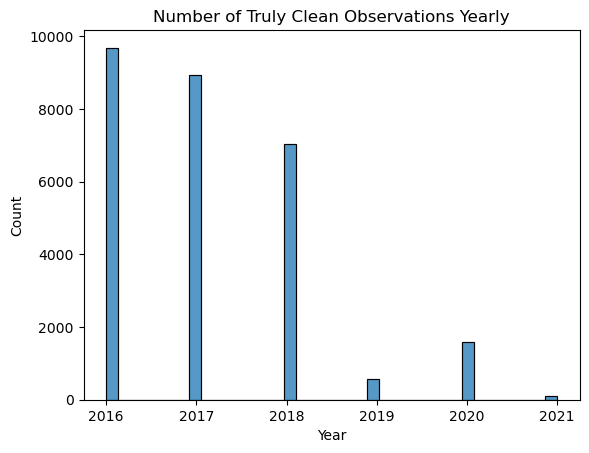

In [8]:
weather_data_clean['year'] = weather_data_clean['date'].dt.year
sns.histplot(data=weather_data_clean.dropna(), x='year')
plt.title("Number of Truly Clean Observations Yearly")
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

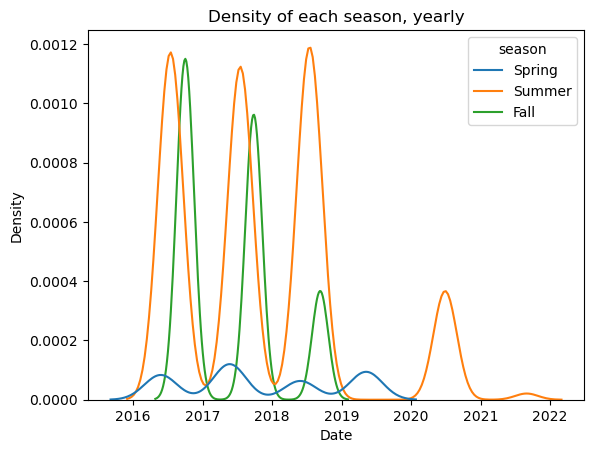

In [9]:
all_clear = weather_data_clean.dropna()
sns.kdeplot(all_clear, x="date", hue='season')
plt.xlabel("Date")
plt.ylabel("Density")
plt.title('Density of each season, yearly')
plt.show()


#### Part 2: Cleaning

Summer has the most consistant count of measurements for the years 2016 - 2018. It may be useful to only consider summer in that time span from here on. I am only home for the summer currently. Let's do it here, so there's an easy out if I change my mind later.

In [10]:
weather_data_clean = weather_data_clean[weather_data_clean['season'] == 'Summer']
weather_data_clean = weather_data_clean[(weather_data_clean['date'].dt.year >= 2016) & (weather_data_clean['date'].dt.year <= 2018)]
weather_data_clean.dropna(inplace=True)

### General Relationships
Now let's get a general idea of the relationships contained in the data. I can go into further detail later.

c:\Users\User\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


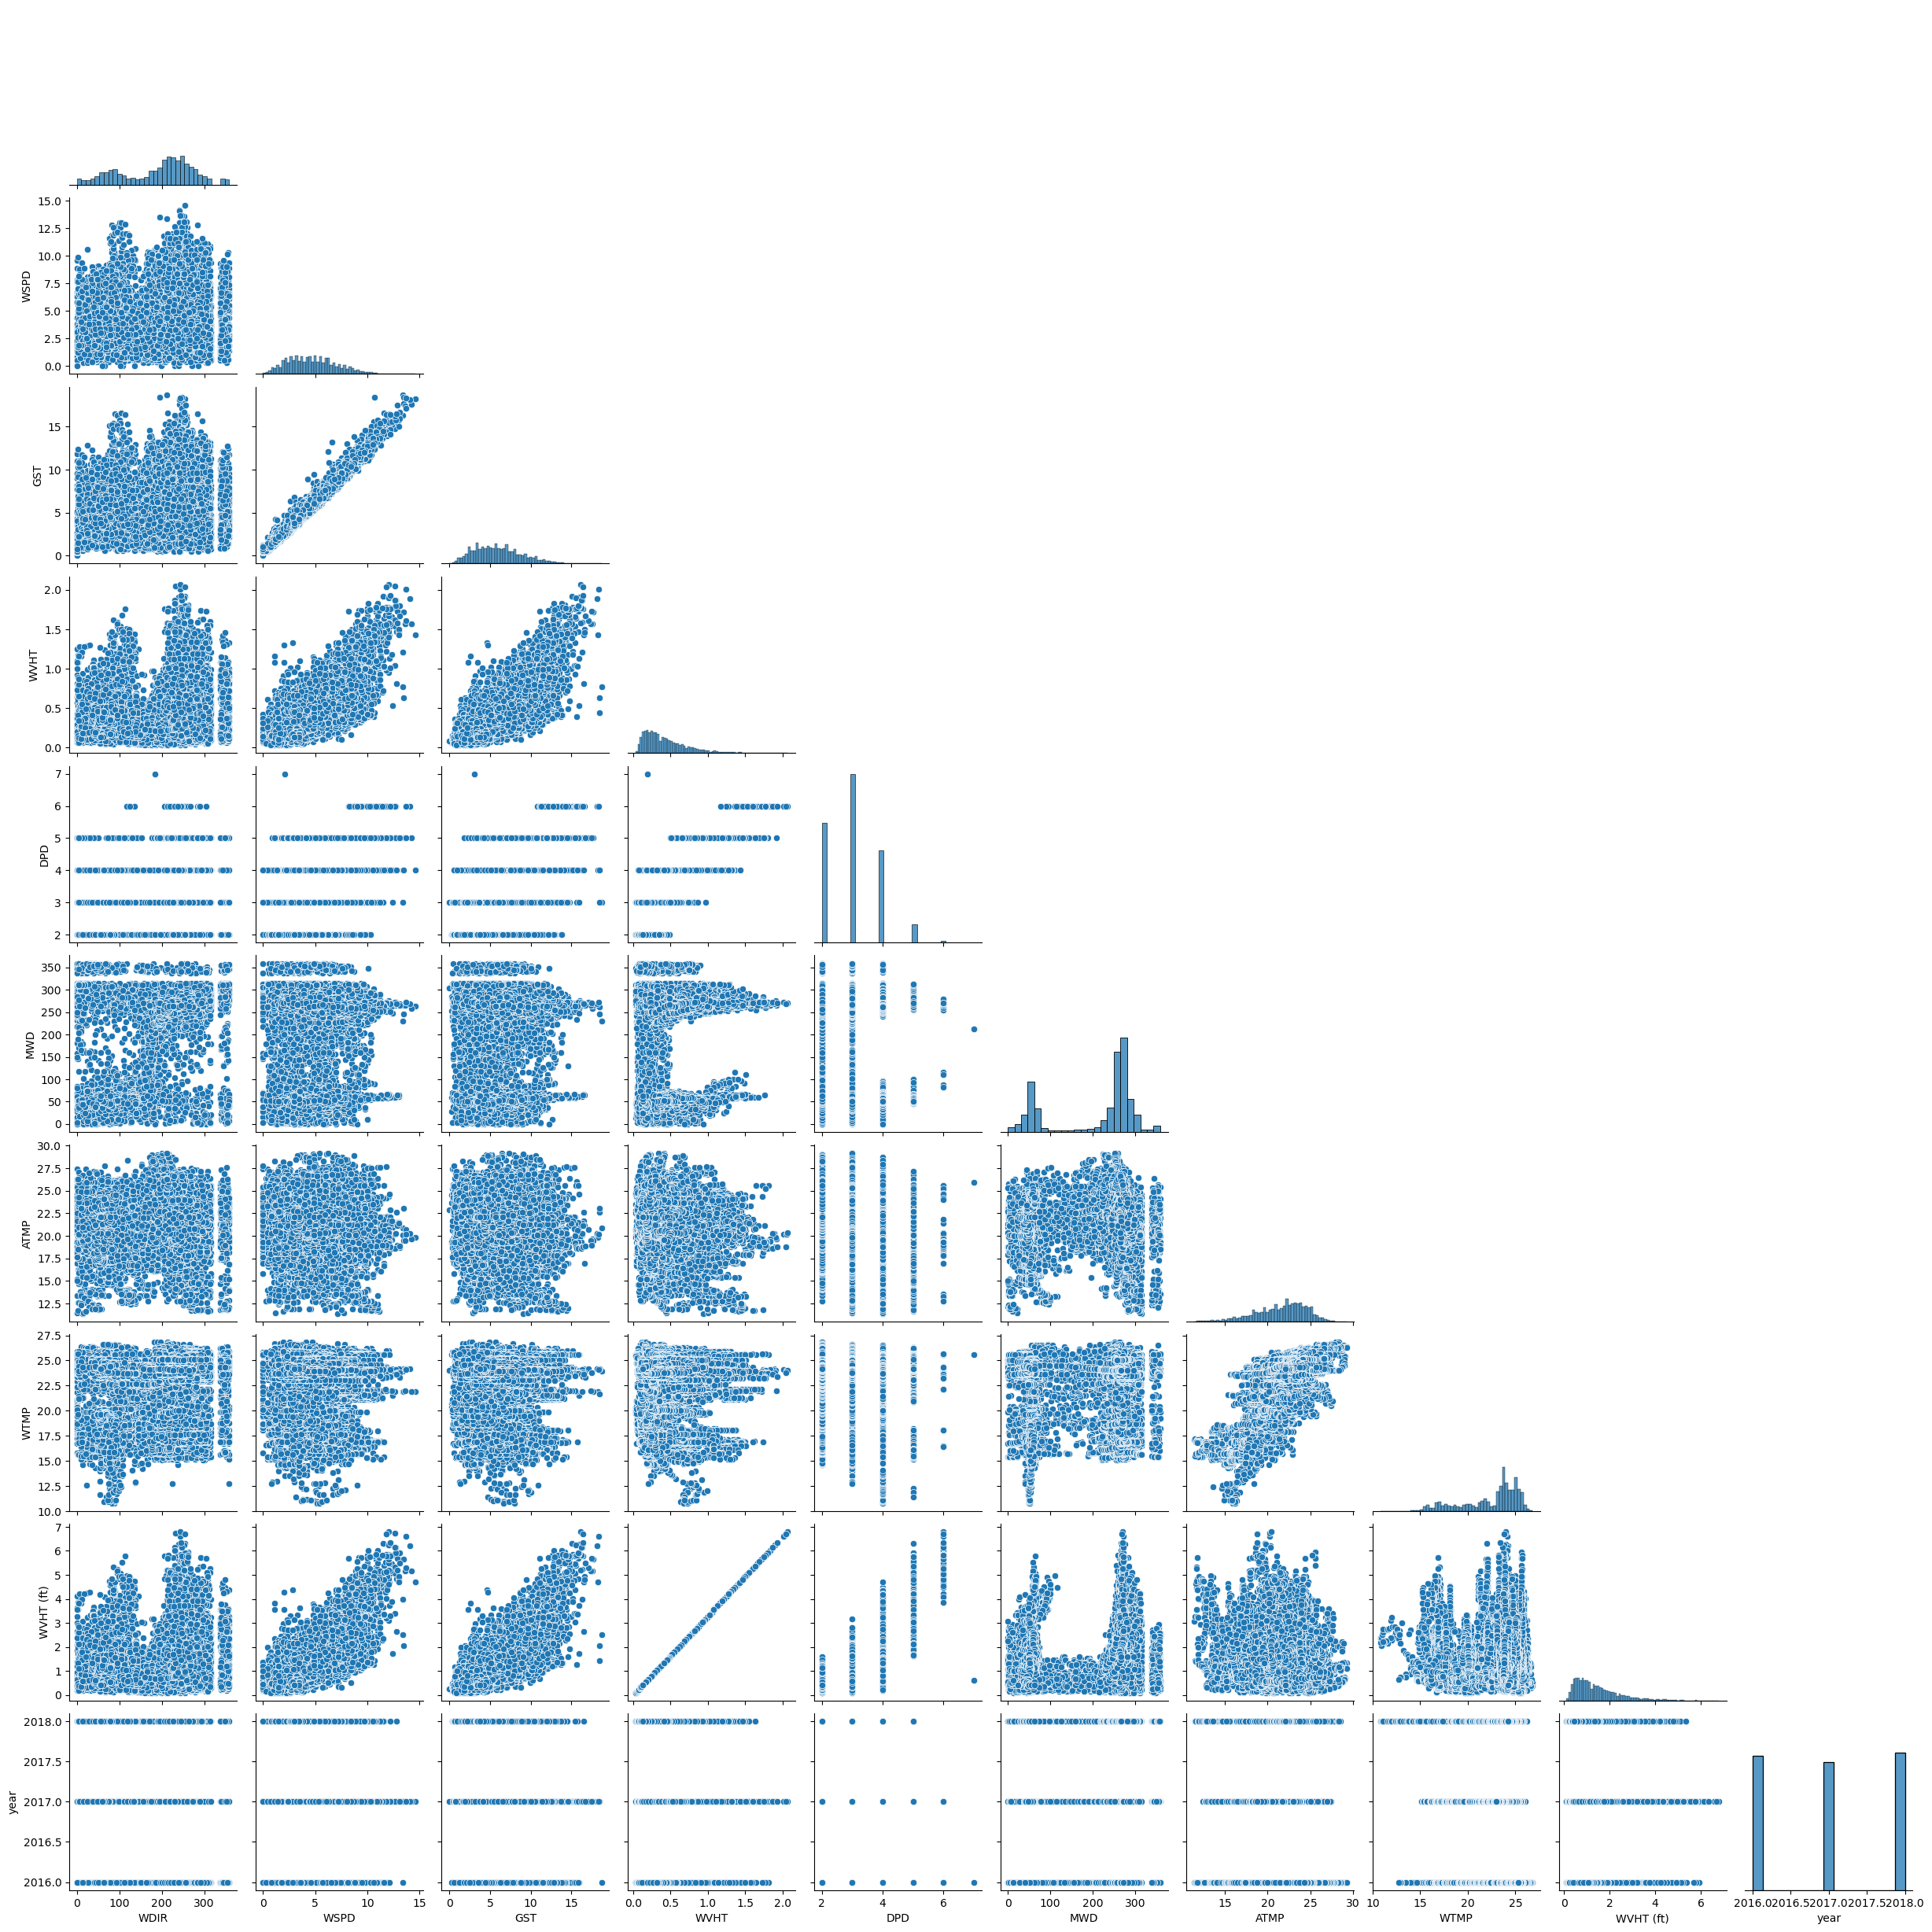

In [11]:
sns.pairplot(data=weather_data_clean.dropna(), corner=True)
plt.show()

- From the chart, WSPD, GST, and DPD, all seem to be somewhat linearly associated with WVHT
  
### Looking into Dominant Wave Period (DPD)
- Defined as the average time (in seconds) between the crest of the waves in a given period.
- I'm thinking there may be some relationships between DPD and wave height. Lets get some more info so I can dig deeper later.

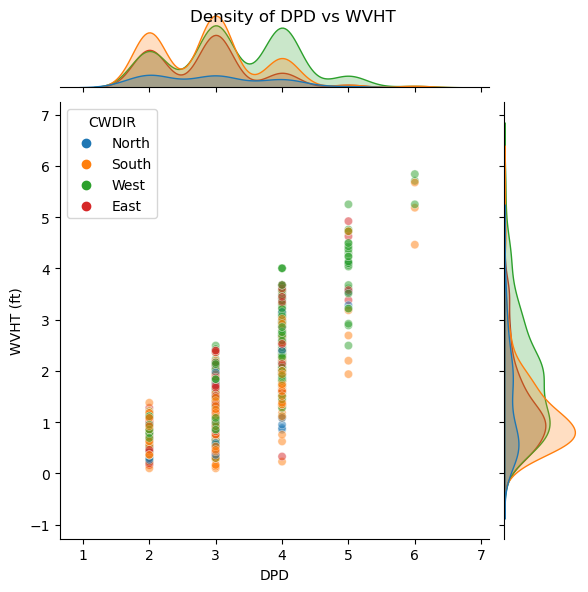

In [12]:
dpd_and_wvht = weather_data_clean.dropna(subset=['DPD', 'WVHT (ft)'])


weather_sample = dpd_and_wvht.sample(1000)
sns.jointplot(
    data=weather_sample, 
    x='DPD', 
    y='WVHT (ft)', 
    # fill=True, 
    hue='CWDIR',
    alpha=0.5) 
    
plt.suptitle('Density of DPD vs WVHT') # Found on geeks for geeks, moves title location to top.
plt.show()

<Axes: xlabel='DPD', ylabel='Count'>

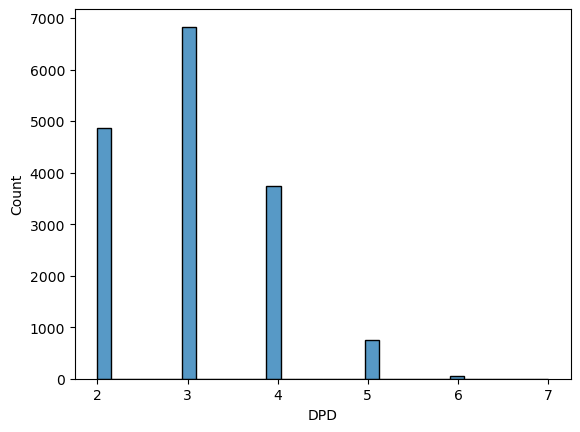

In [13]:
sns.histplot(data=weather_data_clean, x='DPD')

There seems to be a somewhat of a linear association between wvht and dpd. THis could be a predictor of waveheight. It also may be useful to create a metric for danger represented by a combination of high waveheight and low dpd. If we divide waveheight by dpd, we should be able to find the values with the biggest waves and combined with the lowest DPD's. These are our most 'dangerous' measurements. I could try to look into clustering algorithms with wind direction/wave direction to find the most dangerous wind directions.

In [14]:
dpd_and_wvht['danger'] = dpd_and_wvht['WVHT (ft)'] / dpd_and_wvht['DPD']
dpd_and_wvht.sort_values('danger', ascending=False).head(5)

,WDIR,WSPD,GST,WVHT,DPD,MWD,ATMP,WTMP,date,CWDIR,CMWD,season,WVHT (ft),year,danger
30752,254.0,11.5,15.1,1.92,5.0,266.0,19.7,22.0,2017-06-25 19:59:00,West,West,Summer,6.2976,2017,1.25952
33368,255.0,12.7,15.8,1.80,5.0,272.0,18.6,23.7,2017-08-05 13:39:00,West,West,Summer,5.9040,2017,1.18080
33364,258.0,13.1,15.9,1.80,5.0,269.0,18.7,23.8,2017-08-05 12:19:00,West,West,Summer,5.9040,2017,1.18080
30747,254.0,14.6,18.2,1.43,4.0,263.0,19.8,21.9,2017-06-25 18:19:00,West,West,Summer,4.6904,2017,1.17260
33373,259.0,11.8,14.3,1.76,5.0,272.0,18.8,23.3,2017-08-05 15:19:00,West,West,Summer,5.7728,2017,1.15456


This could be useful for clustering later. I can look deeper into how wind direction effects danger.

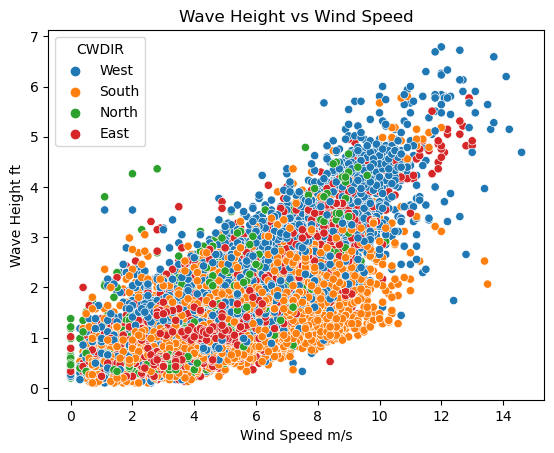

In [15]:
wvht_and_wspd_clean = weather_data_clean.dropna(subset=['WVHT (ft)', 'WSPD'])

sns.scatterplot(data=wvht_and_wspd_clean, 
                x='WSPD', 
                y='WVHT (ft)', 
                hue='CWDIR')

plt.title('Wave Height vs Wind Speed')
plt.xlabel('Wind Speed m/s')
plt.ylabel('Wave Height ft')
plt.show()

### Chart Observations

1. Clearly a linear relationship between wave height and speed, lets try smoothing it and see if there are any differences from wind direction.  
  
  In the chart, the wave height and wind speed look like they have a linear relationship, but they may be grouped in by wind direction. Lets try to smooth and see if there are any differences. I have heard many roumors about different winds being favorable or unfavorable. Lets test that.

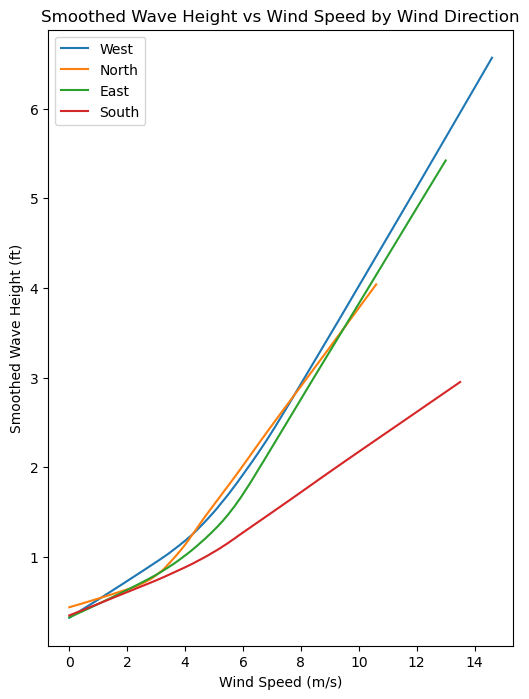

In [16]:
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.figure(figsize=(6, 8))
for dir in wvht_and_wspd_clean['CMWD'].unique():
    
    df = wvht_and_wspd_clean[wvht_and_wspd_clean['CWDIR'] == dir]
    
    y_smooth = lowess(
        df['WVHT (ft)'], df['WSPD'], 
        return_sorted=False)
    
    sns.lineplot(
        x=df['WSPD'],
        y=y_smooth, label=dir)

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Smoothed Wave Height (ft)')
plt.title("Smoothed Wave Height vs Wind Speed by Wind Direction")
plt.legend()
plt.show()

### Chart Observations

1. Waves from south winds are significantly shorter compared to other directions.
   - Likely because shore is south of buoy.
   - Seems unimportant, however this is not somthing I usually consider when reviewing the wave report in the morning.
   
2. Appears that north winds don't get as fast or high as other wind directions. 
3. Very slightly lower east wind curve from roughly 2.5 - 10 m/s
  - Possibly because of land in the distance east


##### Granularity
- The data appears to be weather measurements taken from a buoy off the shore of Presque Isle in Erie Pennsylvania. It appears the buoy measures Windspeed, Wid direction, wind gust, wave height, dominant wave period, water and air temp, and other datapoints every 20 minutes daily. (Exluding winters) For my project, I will only be taking summers into account.

## Part 1b: Daily Airport Weather Data

In [17]:
data = r'./data/erie_airport_weather_data.csv'

airport_data = pd.read_csv(data)
airport_data.dropna(axis=1, inplace=True)
airport_data['DATE'] = pd.to_datetime(airport_data['DATE'], 
                                      format='%Y-%m-%d').dt.date
airport_data

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,WDF2,WDF2_ATTRIBUTES,WSF2,WSF2_ATTRIBUTES
0,USW00014860,"ERIE INTERNATIONAL AIRPORT, PA US",42.08026,-80.18236,222.2,2014-01-01,9.84,",,W",0.25,",,W,2400",5.9,",,W",21,",,W",18,",,W",60,",,W",18.1,",,W"
1,USW00014860,"ERIE INTERNATIONAL AIRPORT, PA US",42.08026,-80.18236,222.2,2014-01-02,20.36,",,W",0.29,",,W,2400",5.9,",,W",18,",,W",10,",,W",40,",,W",29.1,",,W"
2,USW00014860,"ERIE INTERNATIONAL AIRPORT, PA US",42.08026,-80.18236,222.2,2014-01-03,8.28,",,W",0.00,"T,,W,2400",0.0,"T,,W",13,",,W",6,",,W",10,",,W",21.0,",,W"
3,USW00014860,"ERIE INTERNATIONAL AIRPORT, PA US",42.08026,-80.18236,222.2,2014-01-04,19.01,",,W",0.00,",,W,2400",0.0,",,W",35,",,W",13,",,W",190,",,W",29.1,",,W"
4,USW00014860,"ERIE INTERNATIONAL AIRPORT, PA US",42.08026,-80.18236,222.2,2014-01-05,6.49,",,W",0.41,",,W,2400",0.0,",,W",46,",,W",32,",,W",170,",,W",18.1,",,W"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,USW00014860,"ERIE INTERNATIONAL AIRPORT, PA US",42.08026,-80.18236,222.2,2022-12-27,11.18,",,W",0.00,"T,,W,2400",0.0,"T,,W",30,",,W",20,",,W",190,",,W",16.1,",,W"
3283,USW00014860,"ERIE INTERNATIONAL AIRPORT, PA US",42.08026,-80.18236,222.2,2022-12-28,16.55,",,W",0.00,",,W,2400",0.0,",,W",44,",,W",30,",,W",200,",,W",25.9,",,W"
3284,USW00014860,"ERIE INTERNATIONAL AIRPORT, PA US",42.08026,-80.18236,222.2,2022-12-29,16.33,",,W",0.00,",,W,2400",0.0,",,W",59,",,W",42,",,W",200,",,W",25.9,",,W"
3285,USW00014860,"ERIE INTERNATIONAL AIRPORT, PA US",42.08026,-80.18236,222.2,2022-12-30,13.87,",,W",0.00,"T,,W,2400",0.0,",,W",64,",,W",46,",,W",200,",,W",25.9,",,W"


In [18]:
airport_precip = airport_data[['DATE', "PRCP", 'SNOW']]
airport_precip.describe()

,PRCP,SNOW
count,3287.000000,3287.000000
mean,0.120295,0.248159
std,0.269147,1.146219
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.120000,0.000000
max,3.580000,21.800000


Data already looks fairly clean. I just want to be able to look at precipitation along with other buoy variables. I already have other weather attributes calculated.

**Entirely off topic:**
Just want to take a second to shout out my hometown. Max 21.8 inches of snow in 1 day sounds absolutely correct. I bet I can guess the day that heppened too. Sometime around christmas 2017. Off topic but lets see. I believe we had approx 5 ft over 2 days

In [19]:
airport_precip.sort_values(by='SNOW', ascending=False).iloc[:2, :]

,DATE,PRCP,SNOW
1455,2017-12-26,1.00,21.8
1454,2017-12-25,1.77,20.9


- Correction after viewing data. We got a bit more then 3.5 feet in that time. We already had a foot and a half on the ground. 
- This works as validation for the data too. I know it's accurate firsthand. And PRCP/SNOW measures the new amount each day. Helps with understanding granularity of dataset.
   - Source: Me... I remember shoveling show those days, it was up to my chest (I'm 6'7)
  
  
Okay... Let's get back on track.

In [20]:
precip = airport_precip[['DATE', "PRCP"]]

# Part 2: Inference 


First I would like to see how often different wind directions occur, alongside the corresponding wave direction. I can melt the data to do this.

In [21]:
weather_data_clean

,WDIR,WSPD,GST,WVHT,DPD,MWD,ATMP,WTMP,date,CWDIR,CMWD,season,WVHT (ft),year
18920,237.0,2.5,2.8,0.04,3.0,300.0,20.5,19.9,2016-06-01 00:00:00,West,West,Summer,0.1312,2016
18921,243.0,2.6,3.2,0.03,3.0,298.0,20.8,20.3,2016-06-01 00:20:00,West,West,Summer,0.0984,2016
18922,225.0,1.9,2.3,0.04,2.0,309.0,20.3,19.7,2016-06-01 00:40:00,South,West,Summer,0.1312,2016
18923,204.0,2.2,2.5,0.04,3.0,228.0,20.2,20.5,2016-06-01 01:00:00,South,West,Summer,0.1312,2016
18924,255.0,1.1,1.2,0.03,2.0,286.0,20.0,20.0,2016-06-01 01:20:00,West,West,Summer,0.0984,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44548,79.0,2.8,4.5,0.17,2.0,63.0,22.1,24.4,2018-08-31 22:39:00,East,East,Summer,0.5576,2018
44549,59.0,3.0,3.4,0.13,2.0,50.0,22.1,24.3,2018-08-31 22:59:00,East,East,Summer,0.4264,2018
44550,62.0,3.0,3.5,0.13,2.0,50.0,22.1,24.3,2018-08-31 23:19:00,East,East,Summer,0.4264,2018
44551,54.0,3.4,4.2,0.13,2.0,56.0,22.1,24.2,2018-08-31 23:39:00,East,East,Summer,0.4264,2018


In [22]:
melted_data = pd.melt(
    weather_data_clean, 
    value_vars=['CWDIR', 'CMWD'], 
    var_name='Type', 
    value_name='Direction')

melted_data['Type'] = melted_data['Type'].replace({
    'CWDIR': 'Cardinal Wind Direction',
    'CMWD': 'Cardinal Mean Wave Direction'
})

melted_group = melted_data.groupby(['Type', 'Direction']).size().reset_index().rename(columns={0: 'Count'})
melted_group

wave_direction = melted_group[melted_group['Type'] == 'Cardinal Mean Wave Direction']
wind_direction = melted_group[melted_group['Type'] == 'Cardinal Wind Direction']

wave_observations = np.sum(wave_direction['Count'])
wind_observations = np.sum(wind_direction['Count'])

wave_direction['Percentage'] = np.round(wave_direction['Count'] / wave_observations * 100, 2)
wind_direction['Percentage'] = np.round(wind_direction['Count'] / wind_observations * 100, 2)


direction_data = pd.merge(left=wave_direction, right=wind_direction, left_on='Direction', right_on='Direction')
direction_data

C:\Users\User\AppData\Local\Temp\ipykernel_21656\4044602766.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wave_direction['Percentage'] = np.round(wave_direction['Count'] / wave_observations * 100, 2)
C:\Users\User\AppData\Local\Temp\ipykernel_21656\4044602766.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_direction['Percentage'] = np.round(wind_direction['Count'] / wind_observations * 100, 2)


,Type_x,Direction,Count_x,Percentage_x,Type_y,Count_y,Percentage_y
0,Cardinal Mean Wave Direction,East,3433,21.14,Cardinal Wind Direction,3723,22.93
1,Cardinal Mean Wave Direction,North,1515,9.33,Cardinal Wind Direction,1354,8.34
2,Cardinal Mean Wave Direction,South,750,4.62,Cardinal Wind Direction,5192,31.97
3,Cardinal Mean Wave Direction,West,10540,64.91,Cardinal Wind Direction,5969,36.76


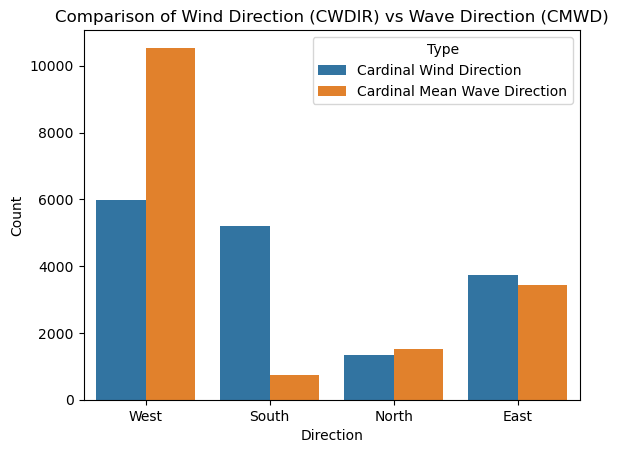

In [23]:
sns.countplot(
    data=melted_data, 
    x='Direction', 
    hue='Type')


plt.title('Comparison of Wind Direction (CWDIR) vs Wave Direction (CMWD)')
plt.xlabel('Direction')
plt.ylabel('Count')
plt.show()

### Chart Observations
1. Wind from the south does not correlate to waves from the south.
2. South wind seems to result in waves from the west

Okay, I think I can start modling wave height based on WSPD, GST, ?DPD?, and?WTMP?

### Moving Forward

1. Try to predict wave height given wind speed, wind direction, DPD, and GST
1. Create a metric to show "bad weather"
   - Combination of wave height, low dpd, 
1. Let's find changes in wave height daily. Then, maybe we can try to figure out what causes the biggest changes

In [24]:
waves = weather_data_clean.copy()

columns = ['WVHT (ft)', 'ATMP', 'WSPD', 'DPD']
aggs = ['min', 'max', 'mean', 'median']


# Create a dictionary where the key is the function we want, and inside is the column name we want, the name we want to give the new column, and the function we want to apply.
agg_dict = {
    f'{func}_{col.lower()}': (col, func)
    for col in columns
    for func in aggs
}

#double astrick unpacks agg_dict s.t key = value. This is an easy way to scale up the groupby function.
wave_group = waves.groupby(
    waves['date'].dt.date
    ).agg(**agg_dict).reset_index()

wave_merge = pd.merge(
    left=wave_group, 
    right=precip, 
    left_on='date', 
    right_on='DATE', 
    how='left')

wave_merge



,date,min_wvht (ft),max_wvht (ft),mean_wvht (ft),median_wvht (ft),min_atmp,max_atmp,mean_atmp,median_atmp,min_wspd,max_wspd,mean_wspd,median_wspd,min_dpd,max_dpd,mean_dpd,median_dpd,DATE,PRCP
0,2016-06-01,0.0984,3.6736,2.143576,2.2796,15.6,20.8,17.710294,17.50,0.6,9.3,6.800000,7.35,2.0,5.0,3.382353,3.0,2016-06-01,0.00
1,2016-06-02,0.4264,1.4760,0.865100,0.8200,16.4,21.7,18.340625,18.20,0.8,7.6,3.906250,3.75,2.0,3.0,2.562500,3.0,2016-06-02,0.03
2,2016-06-03,0.2624,0.8200,0.458634,0.4264,17.0,20.0,18.768966,18.80,0.0,4.2,2.075862,2.00,2.0,3.0,2.586207,3.0,2016-06-03,0.00
3,2016-06-04,0.3608,1.2464,0.703583,0.6560,17.1,20.1,18.476056,18.50,0.0,4.4,2.836620,3.00,2.0,3.0,2.591549,3.0,2016-06-04,0.09
4,2016-06-05,0.3936,3.1488,1.667646,1.9024,16.7,21.4,19.320000,19.20,2.0,11.0,6.178571,6.30,2.0,4.0,3.128571,3.0,2016-06-05,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,2018-08-27,0.5576,1.8696,0.967600,0.8200,21.1,26.1,24.406452,24.05,1.6,5.7,3.559677,3.70,2.0,4.0,2.774194,3.0,2018-08-27,0.16
270,2018-08-28,1.5088,3.9032,2.322745,2.1320,24.7,26.4,25.707692,25.70,1.8,9.7,6.310769,6.90,3.0,5.0,3.923077,4.0,2018-08-28,0.00
271,2018-08-29,1.3448,3.1488,2.157056,2.0664,20.8,26.9,25.075000,25.70,1.9,8.9,5.765278,6.65,3.0,5.0,3.902778,4.0,2018-08-29,0.67
272,2018-08-30,0.9512,2.4600,1.499212,1.4760,19.9,22.9,20.844615,20.40,2.9,7.2,4.827692,4.80,2.0,4.0,3.200000,3.0,2018-08-30,0.00


My mom and friends always point out that when it's raining, it isn't safe to go out. However, I don't have an issue getting wet if it means I'm out on the water. I want to see if rain correlates with bigger waves.

- After researching some basic weather patterns, I am going to assume there is some truth this theory. I will assume the highest wave height of each day is due to rain. 

- I want to find out if rain really effects my safety out on the water. 
  - **(Assuming there are no signs of lightning)** 
1. First, lets select the data we need to analyze, and choose our test metric. Here we are going to use max daily waveheight.

In [25]:
wvht_precip = wave_merge[['date', 'min_wvht (ft)', 'max_wvht (ft)', 'mean_wvht (ft)', 'median_wvht (ft)', 'PRCP']]
wvht_precip.head(5)

,date,min_wvht (ft),max_wvht (ft),mean_wvht (ft),median_wvht (ft),PRCP
0,2016-06-01,0.0984,3.6736,2.143576,2.2796,0.00
1,2016-06-02,0.4264,1.4760,0.865100,0.8200,0.03
2,2016-06-03,0.2624,0.8200,0.458634,0.4264,0.00
3,2016-06-04,0.3608,1.2464,0.703583,0.6560,0.09
4,2016-06-05,0.3936,3.1488,1.667646,1.9024,0.66


2. Next, let's see if there is a change in the percentage of days I can go out depending on rain or no rain.

    - Lets say roughly three and a half foot waves are usually the highest I feel comfortable going in on my boat. 
    - Also let's establish a 'rainy day' has more then 0.01 inches of rain. (I know... a bit different from Oregon.)

In [26]:
max_safe_wvht = 3 # Feet
rain_threshold = 0.01 # Inches
y_func = 'max_wvht (ft)'

Now, let's find the proportion of days that it is safe for me to go out. Aka the percent of days where the wave height does not go above my preferred safe height.

In [27]:
def prop_safe(sample, column):
    days_below_safe = len(sample[sample[column] < max_safe_wvht])
    proportion_safe_days = days_below_safe / len(sample)
    return proportion_safe_days


def sample_df(df, column):
    print(f'The dataframe has {len(df)} entries')
    num_iterations = 100
    sample_size = 50

    results = []
    for _ in range(num_iterations):
        sample = df.sample(sample_size, replace=True)
        proportion_safe = prop_safe(sample, column)
        results.append(proportion_safe)

    return results

In [28]:
no_rain_days = wave_merge[wave_merge['PRCP'] <= rain_threshold]
og_prop_safe_dry = prop_safe(no_rain_days, y_func)
print(f'The proportion of rainy safe days is: {og_prop_safe_dry:.2%}')

all_results_dry = sample_df(no_rain_days, y_func)
average_no_rain = np.average(all_results_dry)

rain_days = wave_merge[wave_merge['PRCP'] > rain_threshold]
og_prop_safe_rain = prop_safe(rain_days, y_func)
print(f'The proportion of rainy safe days is: {og_prop_safe_rain:.2%}')

all_results_rain = sample_df(rain_days, y_func)
average_rain = np.average(all_results_rain)

The proportion of rainy safe days is: 76.63%
The dataframe has 184 entries
The proportion of rainy safe days is: 58.89%
The dataframe has 90 entries


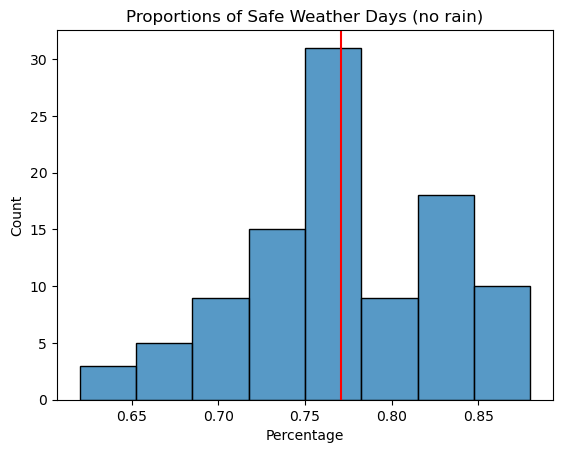

The average proportion of safe days is 77.08% (no rain)


In [29]:
sns.histplot(all_results_dry)
plt.xlabel('Percentage')
plt.axvline(x=np.average(all_results_dry), c='r')
plt.title('Proportions of Safe Weather Days (no rain)')
plt.show()
print(f'The average proportion of safe days is {average_no_rain:.2%} (no rain)')

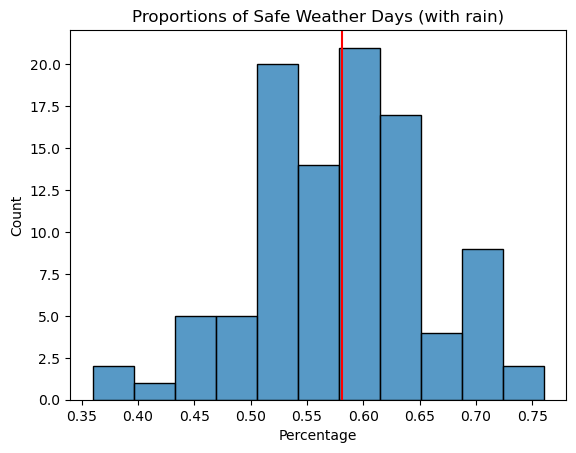

The average proportion of safe days is 58.08% (with rain)


In [30]:
sns.histplot(all_results_rain)
plt.xlabel('Percentage')
plt.axvline(x=np.average(all_results_rain), c='r')
plt.title('Proportions of Safe Weather Days (with rain)')
plt.show()
print(f'The average proportion of safe days is {average_rain:.2%} (with rain)')

There appears to be a significant difference between the percentage of safe days with and without rain. 

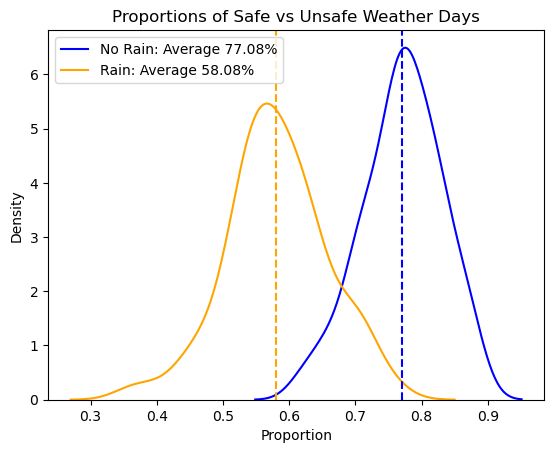

In [31]:
sns.kdeplot(
    all_results_dry, 
    label=f'No Rain: Average {average_no_rain:.2%}',
    c='blue')

sns.kdeplot(
    all_results_rain, 
    label=f'Rain: Average {average_rain:.2%}',
    c='orange')

plt.axvline(
    x=np.average(all_results_dry), 
    c='blue',
    linestyle='--')

plt.axvline(
    x=np.average(all_results_rain), 
    c='orange',
    linestyle='--')
    # label=f'No Rain: Average {average_no_rain:.2%}')

plt.xlabel('Proportion')
plt.title('Proportions of Safe vs Unsafe Weather Days')
plt.legend()
plt.show()


In [32]:
wvht_precip

,date,min_wvht (ft),max_wvht (ft),mean_wvht (ft),median_wvht (ft),PRCP
0,2016-06-01,0.0984,3.6736,2.143576,2.2796,0.00
1,2016-06-02,0.4264,1.4760,0.865100,0.8200,0.03
2,2016-06-03,0.2624,0.8200,0.458634,0.4264,0.00
3,2016-06-04,0.3608,1.2464,0.703583,0.6560,0.09
4,2016-06-05,0.3936,3.1488,1.667646,1.9024,0.66
...,...,...,...,...,...,...
269,2018-08-27,0.5576,1.8696,0.967600,0.8200,0.16
270,2018-08-28,1.5088,3.9032,2.322745,2.1320,0.00
271,2018-08-29,1.3448,3.1488,2.157056,2.0664,0.67
272,2018-08-30,0.9512,2.4600,1.499212,1.4760,0.00


Okay, without any statistical testing there is clearly a significant difference between precipitation and safe wave height. While rain does not have a linear relationship (as seen below) there does appear to be a significant percent change in safety comparing dry days to rainy days.

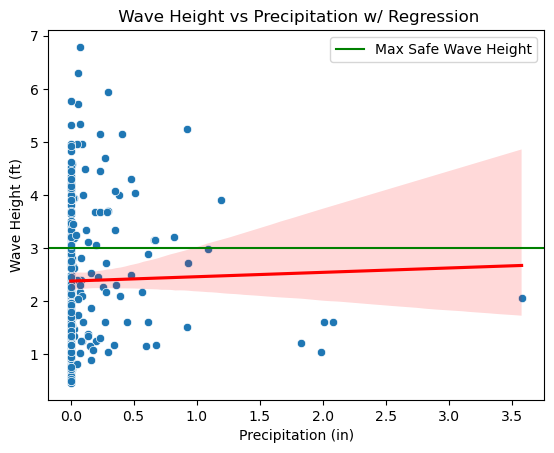

The equation of the regression is roughly: 0.0822x + 2.378
The correlation coefficient of the regression is 0.0238
The p-value associated with the test hypothesis that the slope is 0 is: 0.6954
The standard error is 0.2099


In [33]:
# wvht_precip = wvht_precip[wvht_precip['PRCP'] < 1.5]

# sns.kdeplot(
#     data=wvht_precip, 
#     x='PRCP', 
#     y=y_func, 
#     fill=True)

sns.scatterplot(
    data=wvht_precip, 
    x='PRCP', 
    y=y_func) 
    # fill=True)

sns.regplot(
    data=wvht_precip,
    x='PRCP', 
    y=y_func, 
    marker='', 
    color='r')

plt.axhline(
    y=max_safe_wvht, 
    c='g', 
    label="Max Safe Wave Height")

plt.xlabel("Precipitation (in)")
plt.ylabel("Wave Height (ft)")
plt.legend(loc='upper right')
plt.title(' Wave Height vs Precipitation w/ Regression')
plt.show()

slope, intercept, r, p, sterr = scipy.stats.linregress(x=wvht_precip['PRCP'], y=wvht_precip[y_func])
print(f"The equation of the regression is roughly: {round(slope, 4)}x + {round(intercept, 3)}")
print(f'The correlation coefficient of the regression is {r.round(4)}')
print(f'The p-value associated with the test hypothesis that the slope is 0 is: {p.round(4)}')
print(f'The standard error is {sterr.round(4)}')

From the chart, it is plausable that there is a small positive correlation between max_wvht and precipitation. However, there like we can see above, there is no statistically significant relationship between wave height and precipitation.

**Note:** When removing outlier days (rain greater than an inch and a half) there is a statistically significant positive correlation. This is what can be seen above. 

## More Danger

In [34]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [35]:
dpd_and_wvht.sort_values(by='danger', ascending=False)

,WDIR,WSPD,GST,WVHT,DPD,MWD,ATMP,WTMP,date,CWDIR,CMWD,season,WVHT (ft),year,danger
30752,254.0,11.5,15.1,1.92,5.0,266.0,19.7,22.0,2017-06-25 19:59:00,West,West,Summer,6.2976,2017,1.259520
33368,255.0,12.7,15.8,1.80,5.0,272.0,18.6,23.7,2017-08-05 13:39:00,West,West,Summer,5.9040,2017,1.180800
33364,258.0,13.1,15.9,1.80,5.0,269.0,18.7,23.8,2017-08-05 12:19:00,West,West,Summer,5.9040,2017,1.180800
30747,254.0,14.6,18.2,1.43,4.0,263.0,19.8,21.9,2017-06-25 18:19:00,West,West,Summer,4.6904,2017,1.172600
33373,259.0,11.8,14.3,1.76,5.0,272.0,18.8,23.3,2017-08-05 15:19:00,West,West,Summer,5.7728,2017,1.154560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41498,182.0,1.3,1.6,0.04,3.0,275.0,24.7,25.5,2018-07-16 06:59:00,South,West,Summer,0.1312,2018,0.043733
20153,186.0,2.1,2.4,0.03,3.0,265.0,20.6,19.9,2016-06-19 05:00:00,South,West,Summer,0.0984,2016,0.032800
41495,215.0,1.4,1.7,0.03,3.0,297.0,24.7,25.5,2018-07-16 06:19:00,South,West,Summer,0.0984,2018,0.032800
41496,160.0,0.7,0.9,0.03,3.0,271.0,24.6,25.5,2018-07-16 06:39:00,South,West,Summer,0.0984,2018,0.032800


I'm kind of stuck on this. I want to try to find somthing useful but I'm not sure saying danger > 1 is a good way to measure things. Lets dig into 'dangerous' wave conditions some more.

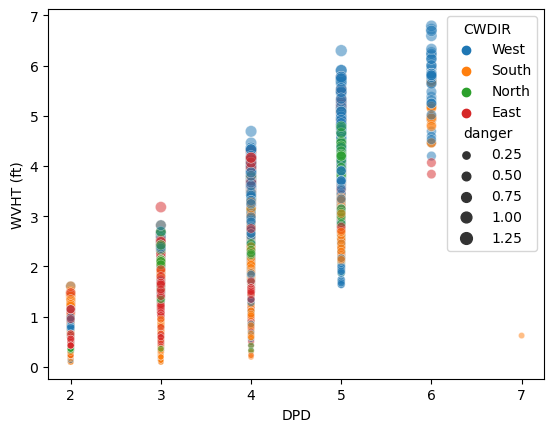

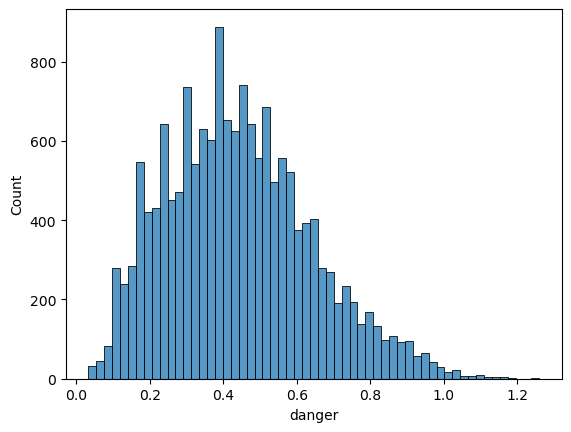

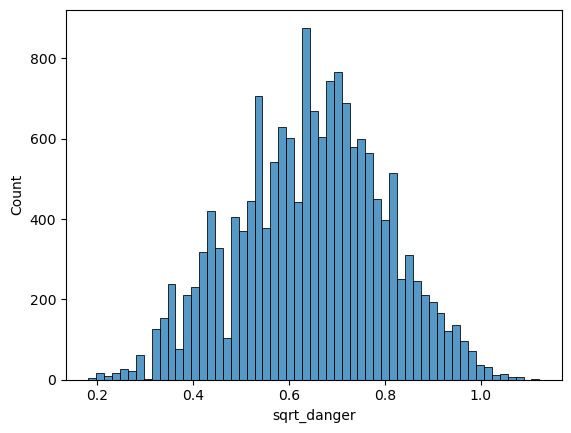

In [36]:
sns.scatterplot(data=dpd_and_wvht, x='DPD', y='WVHT (ft)', size='danger', hue='CWDIR', alpha=0.5)
plt.show()

sns.histplot(data=dpd_and_wvht, x='danger')
plt.show()

dpd_and_wvht['sqrt_danger'] = dpd_and_wvht['danger'] ** 0.5
sns.histplot(data=dpd_and_wvht, x='sqrt_danger')
plt.show()

<Axes: xlabel='DPD', ylabel='WVHT (ft)'>

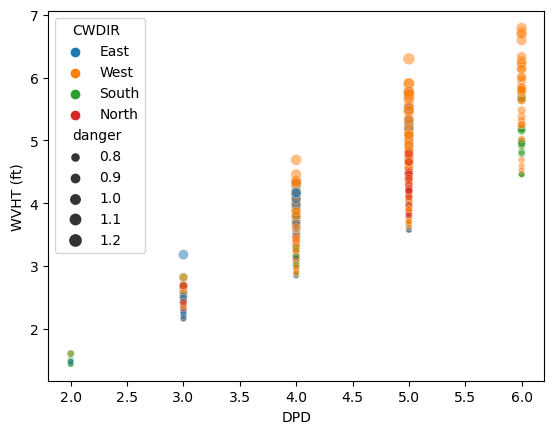

In [37]:
percentile = np.percentile(dpd_and_wvht['sqrt_danger'], 90)
dpd_and_wvht_1 = dpd_and_wvht[dpd_and_wvht['sqrt_danger'] > percentile]  # Semi-arbitrary cutoff representing 'dangerous waves'


sns.scatterplot(data=dpd_and_wvht_1, x='DPD', y='WVHT (ft)', size='danger', hue='CWDIR', alpha=0.5)

In [38]:
dangerous_winds = dpd_and_wvht_1.groupby(['CWDIR'])['sqrt_danger'].size().reset_index().sort_values(by='sqrt_danger', ascending=False)
dangerous_winds

,CWDIR,sqrt_danger
3,West,1018
0,East,329
2,South,149
1,North,95


It's starting to appear west winds are by far the most dangerous. Somthing my dad used to always warn of, I may revisit and look into winds shifting directions. I won't have time for this class, but it is somthing I would love to revisit.

After doing some research online, I want to try a one-way t-test to see how wind direction effects 'danger'. I applied a square root transformation on 'danger' to make the data more normally distributed. (It was close so log10 was too extreme). For this test my Null hypothesis is that there is no difference between group means of danger and caused by wind direction. My alternative hypothesis is that there is at least one group that differs slightly. This test should hopefully confirm my thoughts on south winds greatly negatively influencing 'danger' which is influenced by wave height. I can later then use wind direction in my model.

In [39]:
from scipy.stats import f_oneway

In [40]:
cwdir_danger = dpd_and_wvht[['CWDIR', 'sqrt_danger']]

groups = cwdir_danger.groupby("CWDIR")['sqrt_danger'].apply(np.array).to_list()  # .apply converts to numpy, then I transform it to a list for the oneway test

anova_result = f_oneway(*groups) 

anova_result

F_onewayResult(statistic=362.3396435206292, pvalue=8.510248547550436e-228)

In [41]:
cmwd_danger = dpd_and_wvht[['CMWD', 'sqrt_danger']]

groups = cmwd_danger.groupby("CMWD")['sqrt_danger'].apply(np.array).to_list()  # .apply converts to numpy, then I transform it to a list for the oneway test

anova_result = f_oneway(*groups) 

anova_result

F_onewayResult(statistic=120.05245416015765, pvalue=6.6737687650124834e-77)

This confirms there is a significant difference between the means of sqrt_danger, comparet to wind direction and wave direction.. The F-statistic suggests variance between groups is extremely high compared to variance within groups. With wind direction being over 3x as high. Both have extremely low p-values meaning we must reject the null hypothesis. This, also gives more evidence that I should be able to use 'CWDIR' and 'CMWD' in my analysis. 

## Finding Best Fitting Values

In [42]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

In [43]:
data_subset = ['WSPD', "GST", 'DPD', 'CWDIR', 'CMWD']

subset = weather_data_clean[data_subset].copy()
# subset['BIAS'] = 1

# Residuals appeared to resemble the x^2 equation
subset['WSPD^2'] = np.square(subset['WSPD'])  
subset['GST^2'] = np.square(subset['GST'])
subset['DPD^2'] = np.square(subset['DPD'])

# # Want to try log transformations too 
# subset['log10_WSPD'] = np.log1p(subset['WSPD'])  
# subset['log10_GST'] = np.log1p(subset['GST'])
# subset['log10_DPD'] = np.log1p(subset['DPD'])

# Testing interactions between terms (I'm particularly hoping to unlock DPD a bit more)
subset['WSPD*GST'] = subset['WSPD'] * subset['GST']
subset['WSPD*DPD'] = subset['WSPD'] * subset['DPD']
subset['GST*DPD'] = subset['GST'] * subset['DPD']

subset['GST*DPD*WSPD'] = subset['GST'] * subset['WSPD'] * subset['DPD']

# subset['GST*DPD^2'] = subset['GST*DPD'] ** 2
# subset['WSPD*DPD^2'] = subset['WSPD*DPD'] ** 2
# subset['WSPD*GST^2'] = subset['WSPD*GST'] ** 2

# Include dummy values for wind and wave direction
subset = pd.get_dummies(subset, prefix=['CWDIR', 'CMWD'], columns=['CWDIR', 'CMWD'])

# subset.drop(columns=['WSPD', "GST", 'DPD'], inplace=True)

# subset
y_variable = weather_data_clean['WVHT (ft)']

In [62]:
def lowest_error_features(model, X: pd.DataFrame, y: pd.Series, display_results=False):   
    feature_error = np.empty(0)

    for x_var in X.columns:
        X_train = X[[x_var]]
        Y_train = y

        kf = KFold(n_splits=5)
        validation_errors = np.empty(0)

        for train_idx, valid_idx in kf.split(X_train):

            split_X_train, split_X_valid = X_train.iloc[train_idx, :], X_train.iloc[valid_idx, :]
            split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

            model.fit(split_X_train, split_Y_train)

            Y_pred = model.predict(split_X_valid)

            validation_errors = np.append(validation_errors, mean_squared_error(split_Y_valid, Y_pred))

        feature_error = np.append(feature_error, np.mean(validation_errors))

    feature_errors = pd.DataFrame({'Feature Name': X.columns, 'Feature Error': feature_error})
    feature_errors.sort_values('Feature Error', ascending=True, inplace=True) 
    
    if display_results:
        print(f'The feature errors are:')
        display(feature_errors)

    feature_importance = feature_errors['Feature Name']
    return feature_importance


def best_subset(model, X: pd.DataFrame, y: pd.Series, importance: np.array, display_results=False):
    feature_error = np.empty(0)
    predictors = []

    for i in np.arange(0, len(importance)):
        X_train = X[np.array(importance[0:i+1])]
        Y_train = y
        
        predictors.append(importance[0:i+1].values)

        kf = KFold(n_splits=5)
        validation_errors = np.empty(0)

        for train_idx, valid_idx in kf.split(X_train):

            split_X_train, split_X_valid = X_train.iloc[train_idx,:], X_train.iloc[valid_idx,:]
            split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

            model.fit(split_X_train, split_Y_train)
            Y_pred = model.predict(split_X_valid)

            validation_errors = np.append(validation_errors, mean_squared_error(split_Y_valid, Y_pred))

        feature_error = np.append(feature_error, np.mean(validation_errors))

    best_fits = pd.DataFrame({"subset":predictors, "validation error": feature_error}).sort_values(by='validation error')

    if display_results:
        print(f'The best fits are: ')
        display(best_fits)

    best_fit = best_fits['subset'].iloc[0]
    return best_fit

def find_best(model, X, y, display_results=False):
    best_features = lowest_error_features(model, X, y, display_results)
    best =  best_subset(model, X, y, best_features, display_results)
    return best

In [63]:
model = LinearRegression()

test_subset = find_best(model, subset, y_variable, True)

The feature errors are:


,Feature Name,Feature Error
11,GST*DPD,0.125773
10,WSPD*DPD,0.141565
5,DPD^2,0.275309
2,DPD,0.312697
4,GST^2,0.351342
9,WSPD*GST,0.354754
8,log10_DPD,0.360283
3,WSPD^2,0.366533
1,GST,0.369640
0,WSPD,0.404032


The best fits are: 


,subset,validation error
17,"[GST*DPD, WSPD*DPD, DPD^2, DPD, GST^2, WSPD*GS...",0.084922
16,"[GST*DPD, WSPD*DPD, DPD^2, DPD, GST^2, WSPD*GS...",0.084922
18,"[GST*DPD, WSPD*DPD, DPD^2, DPD, GST^2, WSPD*GS...",0.084936
19,"[GST*DPD, WSPD*DPD, DPD^2, DPD, GST^2, WSPD*GS...",0.084936
15,"[GST*DPD, WSPD*DPD, DPD^2, DPD, GST^2, WSPD*GS...",0.085021
13,"[GST*DPD, WSPD*DPD, DPD^2, DPD, GST^2, WSPD*GS...",0.085177
14,"[GST*DPD, WSPD*DPD, DPD^2, DPD, GST^2, WSPD*GS...",0.085192
12,"[GST*DPD, WSPD*DPD, DPD^2, DPD, GST^2, WSPD*GS...",0.088242
11,"[GST*DPD, WSPD*DPD, DPD^2, DPD, GST^2, WSPD*GS...",0.089976
10,"[GST*DPD, WSPD*DPD, DPD^2, DPD, GST^2, WSPD*GS...",0.090199


## PCA Clustering 
Lets confirm what causes dangerous conditions, and check for colinearity. (**Note: This was done after the prediction section**)

In [64]:
from sklearn.decomposition import PCA

In [65]:
wave_limit = 3
target = (weather_data_clean['WVHT (ft)'] >= wave_limit).reset_index()

target_data = weather_data_clean[['WSPD', "GST", 'DPD', 'CWDIR', 'CMWD']].copy()
target_data = pd.get_dummies(target_data, prefix=['CWDIR', 'CMWD'], columns=['CWDIR', 'CMWD'])


scalar = StandardScaler()
subset_stand = scalar.fit_transform(target_data)

pca = PCA()
pca = PCA(n_components=2)
subset_PCA = pca.fit_transform(subset_stand)

PCA_df = pd.DataFrame(subset_PCA).rename(columns={0: 'PC1', 1:'PC2'})

PCA_df['IsDangerous'] = target['WVHT (ft)']

explained_variance = pca.explained_variance_ratio_
cum_variance = explained_variance.sum()

variance_lost = 1 - cum_variance

print(f'The total variance lost is {variance_lost:.2%}')
PCA_df


The total variance lost is 52.74%


,PC1,PC2,IsDangerous
0,0.654511,-1.445922,False
1,0.712632,-1.359130,False
2,-0.593270,-2.503940,False
3,-0.168706,-2.035178,False
4,-0.075919,-2.371135,False
...,...,...,...
16233,-3.020282,0.950477,False
16234,-3.115236,0.808496,False
16235,-3.104121,0.825105,False
16236,-2.971676,1.022795,False


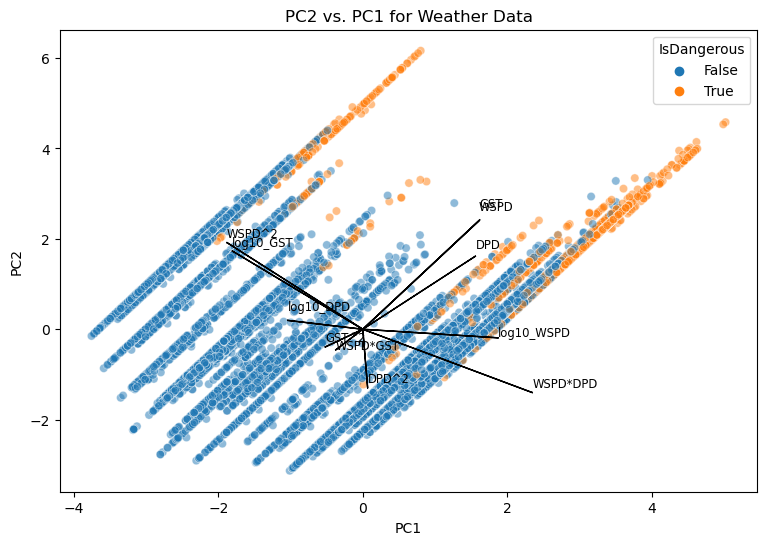

In [66]:
# sns.scatterplot(data=PCA_df, x='PC1', y='PC2', hue='IsDangerous')
plt.figure(figsize=(9, 6))
sns.scatterplot(data=PCA_df, x='PC1', y='PC2', hue='IsDangerous', alpha=0.5)
plt.title("PC2 vs. PC1 for Weather Data")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Add arrows for variable contributions
vt = pca.components_.T  # PCA components
offsets = np.random.uniform(0, 1, vt.shape[0]) * 0.3
for i in range(vt.shape[0]):
    plt.arrow(0, 0, vt[i, 0] * 5, vt[i, 1] * 5, color='black')
    plt.text(vt[i, 0] * 5, vt[i, 1] * 5 + offsets[i], subset.columns[i], fontsize='small')

plt.show()

You can see the higher windspeed, dpd, and gst all lead towards more dangerous wave conditions. 

# Part 3: Prediction
## 1. Linear Regression:
I want to try to predict wave height based on the data provided in the table. 

#### Possible Subsets

In [67]:
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(subset, y_variable, test_size=0.25)

# Use the training data for feature selection
my_model = LinearRegression()
lowest_error_subset = find_best(my_model, X_train_full, y_train_full)

# Train the model on the selected features
X_train = X_train_full[lowest_error_subset]
my_model.fit(X_train, y_train_full)

# Evaluate on the holdout set using the same features
X_holdout_selected = X_holdout[lowest_error_subset]
holdout_predicted_wvht = my_model.predict(X=X_holdout_selected)
holdout_error = mean_squared_error(y_holdout, holdout_predicted_wvht)

# Calculate training error
base_predicted_wvht = my_model.predict(X=X_train)
base_error = mean_squared_error(y_train_full, base_predicted_wvht)

print(f'The training error is: {base_error}')
print(f'The holdout error is: {holdout_error}')


The training error is: 0.08317483124028442
The holdout error is: 0.0853427614360481


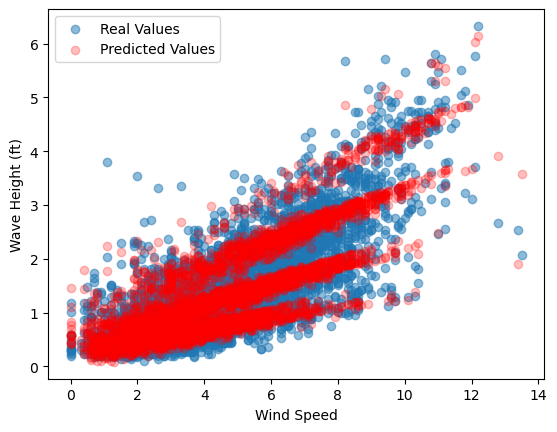

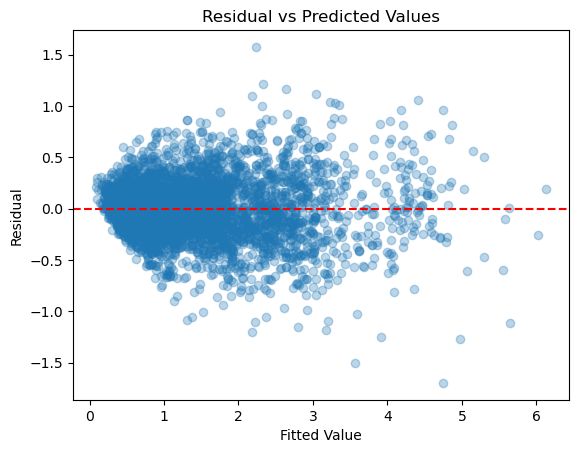

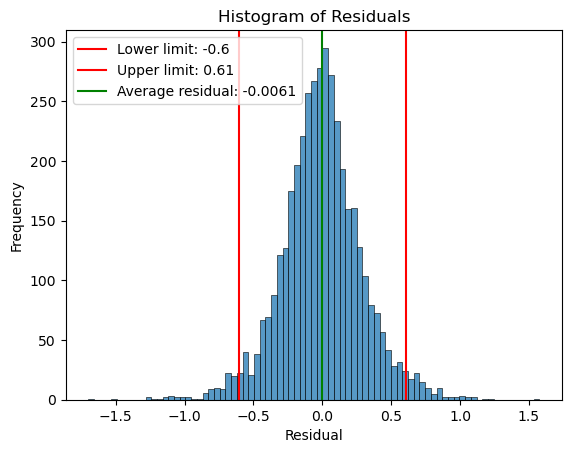

In [68]:
base_comp = 'WSPD'

plt.scatter(
    x=X_holdout[base_comp], 
    y=y_holdout, 
    alpha=0.5,
    label='Real Values')

plt.scatter(
    X_holdout[base_comp], 
    holdout_predicted_wvht, 
    color='r', 
    alpha=0.25,
    label='Predicted Values')

plt.ylabel("Wave Height (ft)")
plt.xlabel("Wind Speed")
plt.legend(loc='upper left')
plt.show()

residuals =  y_holdout - holdout_predicted_wvht

plt.scatter(holdout_predicted_wvht, residuals, alpha=0.3)
plt.title("Residual vs Predicted Values")
plt.xlabel("Fitted Value")
plt.ylabel('Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

lower_limit = np.percentile(residuals, 2.5)
upper_limit = np.percentile(residuals, 97.5)
average_resid = np.average(residuals)

sns.histplot(residuals)
plt.title("Histogram of Residuals")

plt.axvline(
    x=lower_limit, 
    c='r',
    label=f'Lower limit: {np.round(lower_limit, 2)}')

plt.axvline(
    x=upper_limit,
    c='r',
    label=f'Upper limit: {np.round(upper_limit, 2)}')

plt.axvline(
    x=average_resid,
    c='g',
    label=f'Average residual: {np.round(average_resid, 5)}'
)

plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.legend()
plt.show()

This model seems to be fairly accurate. Now, let's try everything I considered, and use ridge regression to select the best features. 

## 2. Ridge Regression

In [85]:
data_subset = ['WSPD', "GST", 'DPD', 'CWDIR', 'CMWD']

subset = weather_data_clean[data_subset].copy()
# subset['BIAS'] = 1

# Residuals appeared to resemble the x^2 equation
subset['WSPD^2'] = np.square(subset['WSPD'])  
subset['GST^2'] = np.square(subset['GST'])
subset['DPD^2'] = np.square(subset['DPD'])

# Want to try log transformations too 

subset['log10_WSPD'] = np.log1p(subset['WSPD'])  
subset['log10_GST'] = np.log1p(subset['GST'])
subset['log10_DPD'] = np.log1p(subset['DPD'])

# Testing interactions between terms (I'm particularly hoping to unlock DPD a bit more)
subset['WSPD*GST'] = subset['WSPD'] * subset['GST']
subset['WSPD*DPD'] = subset['WSPD'] * subset['DPD']
subset['GST*DPD'] = subset['GST'] * subset['DPD']

# subset['GST*DPD*WSPD'] = subset['GST'] * subset['WSPD'] * subset['DPD']

# subset['GST*DPD^2'] = subset['GST*DPD'] ** 2
# subset['WSPD*DPD^2'] = subset['WSPD*DPD'] ** 2
# subset['WSPD*GST^2'] = subset['WSPD*GST'] ** 2

# Include dummy values for wind and wave direction
subset = pd.get_dummies(subset, prefix=['CWDIR', 'CMWD'], columns=['CWDIR', 'CMWD'])

# subset.drop(columns=['WSPD', "GST", 'DPD'], inplace=True)

# subset
y_variable = weather_data_clean['WVHT (ft)']

In [86]:

# Train-test split
scaler = StandardScaler()
subset_scale = scaler.fit_transform(subset)
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(subset_scale, y_variable, test_size=0.25)

# Perform ridge regression directly on all features
alphas = 10**np.linspace(-5, 4, 40)
error_vs_alpha = pd.DataFrame(columns=["alpha", "Training Error", "Holdout Error"])

for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train_full, y_train_full)

    train_predictions = model.predict(X_train_full)
    holdout_predictions = model.predict(X_holdout)

    train_error = mean_squared_error(y_train_full, train_predictions)
    holdout_error = mean_squared_error(y_holdout, holdout_predictions)

    error_vs_alpha.loc[len(error_vs_alpha)] = [alpha, train_error, holdout_error]

# Find best alpha
best_alpha = error_vs_alpha.sort_values(by="Holdout Error").iloc[0]["alpha"]

# Train final model
best_model = Ridge(alpha=best_alpha)
best_model.fit(X_train_full, y_train_full)

res_train_full = best_model.predict(X_train_full)
res_holdout = best_model.predict(X_holdout)


# Evaluate final model
train_error = mean_squared_error(y_train_full, res_train_full)
holdout_error = mean_squared_error(y_holdout, res_holdout)

print(f"Best alpha: {best_alpha}")
print(f"Training error: {train_error}")
print(f"Holdout error: {holdout_error}")

Best alpha: 1e-05
Training error: 0.0842163336859432
Holdout error: 0.08206411425316791


In [87]:
coefficients = best_model.coef_
values = subset.columns

result = pd.DataFrame({
    'values': values,
    'coefficients': coefficients})
result['abs'] = np.abs(result['coefficients'])
result.sort_values(by='abs', ascending=False, inplace=True)
result

,values,coefficients,abs
9,WSPD*GST,3.213196,3.213196
2,DPD,2.948525,2.948525
4,GST^2,-2.738515,2.738515
8,log10_DPD,-1.799376,1.799376
11,GST*DPD,1.725805,1.725805
10,WSPD*DPD,-0.983135,0.983135
5,DPD^2,-0.956407,0.956407
3,WSPD^2,-0.694204,0.694204
1,GST,0.578154,0.578154
0,WSPD,-0.296765,0.296765


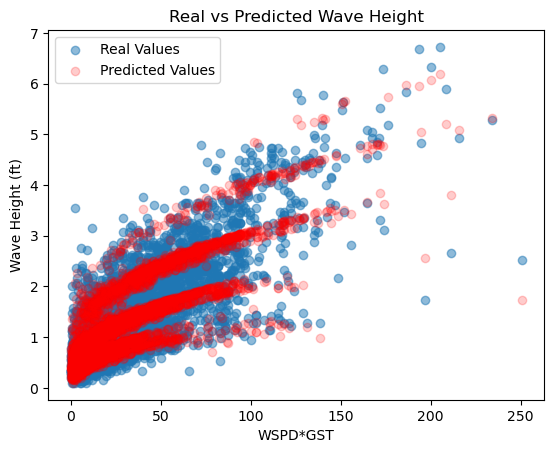

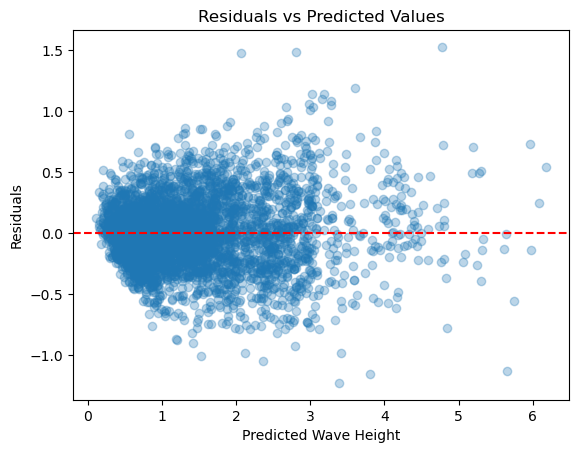

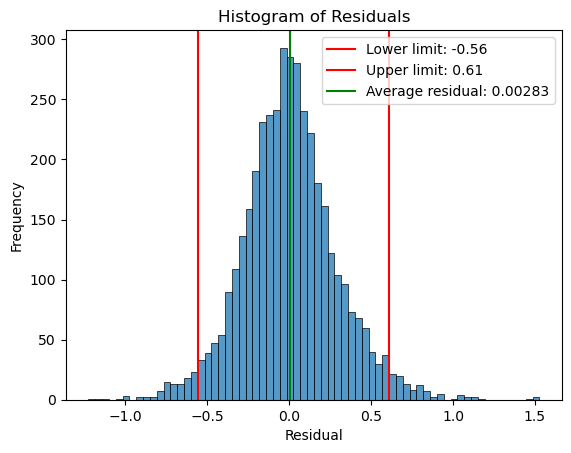

In [88]:
base_comp = result.iloc[0][0]
# base_comp = 'WSPD'

X_holdout_original = scaler.inverse_transform(X_holdout) # Scale the values back to their initial sizes
base_comp_index = subset.columns.get_loc(base_comp) # Get the index of the comparison value

plt.scatter(
    x=X_holdout_original[:, base_comp_index],  # Reverse-scaled values
    y=y_holdout,
    alpha=0.5,
    label='Real Values')

plt.scatter(
    x=X_holdout_original[:, base_comp_index],  # Reverse-scaled values
    y=res_holdout,
    color='r',
    alpha=0.2,
    label='Predicted Values')

plt.ylabel("Wave Height (ft)")
plt.xlabel(base_comp)
plt.legend(loc='upper left')
plt.title("Real vs Predicted Wave Height")
plt.show()

# Residuals
residuals = y_holdout - res_holdout

plt.scatter(res_holdout, residuals, alpha=0.3)
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Wave Height")
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

lower_limit = np.percentile(residuals, 2.5)
upper_limit = np.percentile(residuals, 97.5)
average_resid = np.average(residuals)

sns.histplot(residuals)
plt.title("Histogram of Residuals")
plt.axvline(
    x=lower_limit, 
    c='r',
    label=f'Lower limit: {np.round(lower_limit, 2)}')
plt.axvline(
    x=upper_limit,
    c='r',
    label=f'Upper limit: {np.round(upper_limit, 2)}')
plt.axvline(
    x=average_resid,
    c='g',
    label=f'Average residual: {np.round(average_resid, 5)}'
)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Usually the best predictor is WSPD*GST, occationally it is DPD. When this is the case, the training error seems to be lower, however the final models holout error is generally higher

## PCA Ridge Regression

In [89]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [90]:

# Sclae Data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(subset)


# I started digging into better ways to analyze with PCA while trying to get better intuition of it. 
# Ended up getting some advice from ChatGPT to test for high fit then apply to a linear model (Ridge Regression here).
# I believe this could be a way of avoiding colinearity, but my understanding may be incorrect. I'd love feedback on this approach.
# I've spent some good time poking around and understand what is going on. Feel free to ask questions.

from sklearn.model_selection import cross_val_score

errors = []
for n in range(1, X_standardized.shape[1] + 1):
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X_standardized)
    ridge = Ridge(alpha=best_alpha)
    error = -np.mean(cross_val_score(ridge, X_reduced, y_variable, cv=5)) # We need to minimize instead of maximize
    errors.append(error)

n_components = np.argmin(errors) + 1 # Returns the index optimum number of components
print(f"Optimal number of components: {n_components}")


# Transform data with the chosen # components
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_standardized)


pca_columns = [f"PC{i+1}" for i in range(n_components)]
subset_pca = pd.DataFrame(X_pca_reduced, columns=pca_columns)
display(subset_pca)


Optimal number of components: 18


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,-2.286616,-2.116135,-0.604888,-0.970636,-0.066918,0.043558,0.462678,-0.128666,0.140684,0.136094,-0.219444,-0.002672,0.133139,0.048438,0.006130,0.000485,0.004938,0.002383
1,-2.077784,-2.048837,-0.537500,-1.001218,-0.042371,0.037998,0.425640,-0.126174,0.039109,0.141365,-0.094573,-0.029470,0.086016,-0.009203,0.003172,0.001168,0.004888,-0.000167
2,-3.895441,-0.938277,1.375027,0.719706,-0.762242,-0.409892,-0.691926,0.133664,0.723571,-0.298027,0.000045,-0.047959,0.034444,0.014870,-0.004533,-0.008090,-0.004374,0.000240
3,-2.784688,-1.497227,0.232438,1.468570,-1.076504,-0.409826,-0.198568,0.095319,0.279341,0.102555,-0.183482,-0.028522,0.116051,0.045889,0.002750,-0.003685,0.004347,0.001701
4,-4.529143,-1.958183,0.107793,-1.499456,0.117936,0.091912,0.226055,-0.120158,1.490000,-0.189594,-0.159225,-0.035325,0.022660,0.185951,-0.018982,-0.034322,0.000860,0.003757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16233,-2.912193,2.672555,-0.729871,-1.176127,-0.918834,0.321925,-0.325493,0.165814,0.116206,-0.160156,0.457828,-0.040765,-0.089529,-0.144263,0.038839,-0.022577,-0.000903,0.005109
16234,-3.224426,2.571371,-0.828824,-1.135712,-0.961814,0.327995,-0.279139,0.166104,0.218509,-0.272481,-0.069256,0.034088,0.076772,0.021177,-0.007306,0.004908,-0.005405,0.001713
16235,-3.187049,2.583845,-0.816166,-1.141268,-0.956938,0.327072,-0.285587,0.166434,0.202297,-0.264106,-0.028871,0.029225,0.062649,0.005728,-0.003847,0.003391,-0.005124,0.000672
16236,-2.749339,2.731895,-0.659951,-1.209880,-0.903467,0.317493,-0.367713,0.174906,0.039899,-0.235794,0.066127,0.035957,0.024900,-0.022549,0.003675,0.000698,-0.004065,-0.001043


In [91]:
X_pca_reduced = pca.transform(X_standardized)  
y_variable = weather_data_clean['WVHT (ft)']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y_variable, test_size=0.25)

alphas = 10**np.linspace(-5, 4, 40)
error_vs_alpha = pd.DataFrame(columns=["alpha", "Training Error", "Holdout Error"])

for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)

    train_predictions = model.predict(X_train)
    holdout_predictions = model.predict(X_test)

    train_error = mean_squared_error(y_train, train_predictions)
    holdout_error = mean_squared_error(y_test, holdout_predictions)

    error_vs_alpha.loc[len(error_vs_alpha)] = [alpha, train_error, holdout_error]

# Find best alpha
best_alpha = error_vs_alpha.sort_values(by="Holdout Error").iloc[0]["alpha"]

# Train final model
best_model = Ridge(alpha=best_alpha)
best_model.fit(X_train, y_train)

res_train_full = best_model.predict(X_train)
res_holdout = best_model.predict(X_test)


# Evaluate final model
train_error = mean_squared_error(y_train, res_train_full)
holdout_error = mean_squared_error(y_test, res_holdout)

print(f"Best alpha: {best_alpha}")
print(f"Training error: {train_error}")
print(f"Holdout error: {holdout_error}")

Best alpha: 1e-05
Training error: 0.08358660804712106
Holdout error: 0.0840184436414108


Okay... This ended up interesting. I'm getting similar train-test error compared to the other ridge regression model. However, I'm not getting arithmatic warnings. I guess that's cool, it's an interesting way to compress data.


Congrats!! You finally finished grading this! I know it's a lot. I really enjoyed the freedom this project offered. Instead of studying for my Intro to Proof Class I've spent many nights playing around in this Notebook. My laptop heats 10 degrees as soon as I run this file. This has serously been my favorite class I've taken so far at this school. I like to think my grade so far reflects that. Thank you for this oppertunity and this program. So many people have come to me skeptical about what I've been learning but there is so much power in data. All I want to do is keep learning!